In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


# Deep learning packages
from keras.models import Sequential
from keras.layers import LSTM, Dense

#enable IPython to display matplolib graphs
%matplotlib inline


2022-03-24 14:17:33.624227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-24 14:17:33.624244: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from ML_classes.LinearModel import LinearModel


In [3]:
df = pd.read_csv('./data/ouput.csv')
df.describe()
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")
df.max()

LCLid                       MAC000181
tstp              2014-02-28 00:00:00
energy(kWh/hh)                  4.595
dtype: object

In [4]:
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")

#max_value_energy = df["energy(kWh/hh)"].max()
#df['energy(kWh/hh)'] = df['energy(kWh/hh)'].apply(lambda x: x / max_value_energy)
# Sorting the values
#df.sort_values('tstp', inplace=True)

In [5]:
#df["energy(kWh/hh)"].describe()
#df.max()
#df.describe()

In [6]:
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000150")
hh.pop("LCLid")
#hh = hh.set_index("tstp")
#hh = hh.resample("H").sum()
#hh = hh.reset_index()

hh_max = hh['energy(kWh/hh)'].max()
hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)

/tmp/ipykernel_51092/194026773.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)


In [7]:
#hh["energy(kWh/hh)"].describe()
#len(hh["energy(kWh/hh)"])

In [8]:
# Initiating the class
deep_learner = LinearModel(
data = hh,
Y_var = 'energy(kWh/hh)',
lag = 48,
epochs = 20,
batch_size = 256,
train_test_split = 0.15
)

In [9]:
# Fitting the model

model = deep_learner.LinearModel()

2022-03-24 14:17:36.757386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-24 14:17:36.757843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-24 14:17:36.757897: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-24 14:17:36.757941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-24 14:17:36.757982: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Epoch 1/20
132/132 [==============================] - 0s 1ms/step - loss: 0.0148 - val_loss: 0.0110
Epoch 2/20
132/132 [==============================] - 0s 668us/step - loss: 0.0086 - val_loss: 0.0085
Epoch 3/20
132/132 [==============================] - 0s 577us/step - loss: 0.0070 - val_loss: 0.0072
Epoch 4/20
132/132 [==============================] - 0s 546us/step - loss: 0.0061 - val_loss: 0.0063
Epoch 5/20
132/132 [==============================] - 0s 536us/step - loss: 0.0055 - val_loss: 0.0058
Epoch 6/20
132/132 [==============================] - 0s 708us/step - loss: 0.0051 - val_loss: 0.0054
Epoch 7/20
132/132 [==============================] - 0s 564us/step - loss: 0.0049 - val_loss: 0.0052
Epoch 8/20
132/132 [==============================] - 0s 640us/step - loss: 0.0047 - val_loss: 0.0050
Epoch 9/20
132/132 [==============================] - 0s 659us/step - loss: 0.0045 - val_loss: 0.0049
Epoch 10/20
132/132 [==============================] - 0s 634us/step - loss: 0.0044 

In [10]:
deep_learner.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 49        
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


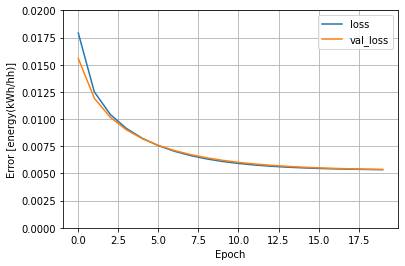

In [24]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.02])
    plt.xlabel('Epoch')
    plt.ylabel('Error [energy(kWh/hh)]')
    plt.legend()
    plt.grid(True)
plot_loss(deep_learner.history)

In [12]:
# Defining the lag that we used for training of the model 
lag_model = 48
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
X, _ = deep_learner.dc.create_X_Y(ts, lag=lag_model)
# Getting the forecast
yhat = model.predict(X)

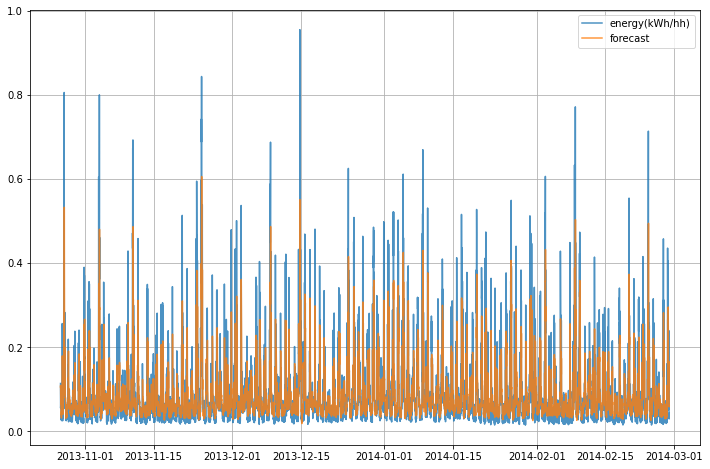

In [13]:
yhat = deep_learner.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

/tmp/ipykernel_51092/2078647226.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fc = fc.append(hat_frame)


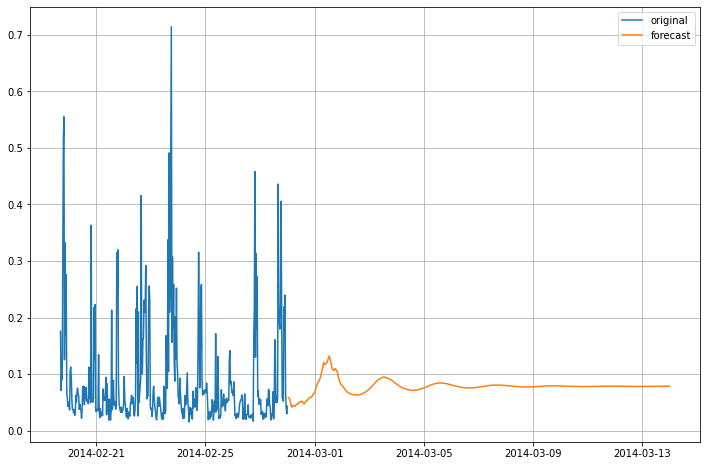

In [14]:

#Forecasting n steps ahead
n_ahead = 168*2
yhat = deep_learner.predict_n_ahead(n_ahead)
yhat = [y[0][0] for y in yhat]

#Constructing the forecast dataframe
fc = hh.tail(400).copy() 
fc['type'] = 'original'

last_date = max(fc['tstp'])
hat_frame = pd.DataFrame({
    'tstp': [last_date + timedelta(hours=x + 1) for x in range(n_ahead)], 
    'energy(kWh/hh)': yhat,
    'type': 'forecast'
})

fc = fc.append(hat_frame)
fc.reset_index(inplace=True, drop=True)
#Ploting the forecasts 
plt.figure(figsize=(12, 8))
for col_type in ['original', 'forecast']:
    plt.plot(
        'tstp', 
        'energy(kWh/hh)', 
        data=fc[fc['type']==col_type],
        label=col_type
        )

plt.legend()
plt.grid()   

In [15]:
deep_learner.evaluateMSE()

0.004604522332403403

In [16]:
deep_learner.evaluateRMSE()

0.06785663071803229

In [17]:
deep_learner.evaluateMAE()

0.03713756171184349

In [18]:
deep_learner.evaluateMAPE()

47.76751561758399

In [19]:
yhat =deep_learner.predict()

In [20]:
#train for all houses
lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in lclid_list:
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()

    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    
    # Initiating the class
    deep_learner = LinearModel(
    data = hh,
    Y_var = 'energy(kWh/hh)',
    lag = 48,
    epochs = 20,
    batch_size = 256,
    train_test_split = 0.15
    )
    #training
    model = deep_learner.LinearModel()
    
    mse.append(deep_learner.evaluateMSE())
    rmse.append(deep_learner.evaluateRMSE())
    mae.append(deep_learner.evaluateMAE())
    mape.append(deep_learner.evaluateMAPE())
houses = pd.Series(data=lclid_list,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape



Epoch 1/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0091 - val_loss: 0.0146
Epoch 2/20
66/66 [==============================] - 0s 713us/step - loss: 0.0076 - val_loss: 0.0126
Epoch 3/20
66/66 [==============================] - 0s 730us/step - loss: 0.0065 - val_loss: 0.0110
Epoch 4/20
66/66 [==============================] - 0s 996us/step - loss: 0.0056 - val_loss: 0.0098
Epoch 5/20
66/66 [==============================] - 0s 651us/step - loss: 0.0050 - val_loss: 0.0089
Epoch 6/20
66/66 [==============================] - 0s 622us/step - loss: 0.0046 - val_loss: 0.0081
Epoch 7/20
66/66 [==============================] - 0s 689us/step - loss: 0.0042 - val_loss: 0.0076
Epoch 8/20
66/66 [==============================] - 0s 633us/step - loss: 0.0039 - val_loss: 0.0071
Epoch 9/20
66/66 [==============================] - 0s 696us/step - loss: 0.0037 - val_loss: 0.0068
Epoch 10/20
66/66 [==============================] - 0s 585us/step - loss: 0.0035 - val_loss: 0.0065
E

66/66 [==============================] - 0s 774us/step - loss: 0.0274 - val_loss: 0.0297
Epoch 3/20
66/66 [==============================] - 0s 734us/step - loss: 0.0229 - val_loss: 0.0248
Epoch 4/20
66/66 [==============================] - 0s 718us/step - loss: 0.0207 - val_loss: 0.0225
Epoch 5/20
66/66 [==============================] - 0s 642us/step - loss: 0.0193 - val_loss: 0.0210
Epoch 6/20
66/66 [==============================] - 0s 585us/step - loss: 0.0181 - val_loss: 0.0197
Epoch 7/20
66/66 [==============================] - 0s 732us/step - loss: 0.0171 - val_loss: 0.0185
Epoch 8/20
66/66 [==============================] - 0s 509us/step - loss: 0.0160 - val_loss: 0.0174
Epoch 9/20
66/66 [==============================] - 0s 550us/step - loss: 0.0151 - val_loss: 0.0164
Epoch 10/20
66/66 [==============================] - 0s 725us/step - loss: 0.0142 - val_loss: 0.0155
Epoch 11/20
66/66 [==============================] - 0s 708us/step - loss: 0.0134 - val_loss: 0.0147
Epoch 12/

66/66 [==============================] - 0s 636us/step - loss: 0.0341 - val_loss: 0.0114
Epoch 4/20
66/66 [==============================] - 0s 775us/step - loss: 0.0276 - val_loss: 0.0109
Epoch 5/20
66/66 [==============================] - 0s 694us/step - loss: 0.0230 - val_loss: 0.0105
Epoch 6/20
66/66 [==============================] - 0s 585us/step - loss: 0.0200 - val_loss: 0.0102
Epoch 7/20
66/66 [==============================] - 0s 630us/step - loss: 0.0182 - val_loss: 0.0100
Epoch 8/20
66/66 [==============================] - 0s 700us/step - loss: 0.0171 - val_loss: 0.0098
Epoch 9/20
66/66 [==============================] - 0s 665us/step - loss: 0.0164 - val_loss: 0.0095
Epoch 10/20
66/66 [==============================] - 0s 693us/step - loss: 0.0158 - val_loss: 0.0093
Epoch 11/20
66/66 [==============================] - 0s 657us/step - loss: 0.0154 - val_loss: 0.0091
Epoch 12/20
66/66 [==============================] - 0s 630us/step - loss: 0.0149 - val_loss: 0.0088
Epoch 13

In [21]:
res_df

,lclid,mse,rmse,mae,mape
0,MAC000168,0.005221,0.072259,0.034784,138.599321
1,MAC000169,0.004943,0.070306,0.043111,53.589833
2,MAC000179,0.004041,0.063568,0.035883,43.935574
3,MAC000181,0.003238,0.056902,0.028353,36.626691
4,MAC000165,0.009876,0.099377,0.069782,41.956325
5,MAC000173,0.011219,0.105920,0.072908,55.748126
6,MAC000152,0.009388,0.096891,0.059396,119.803993
7,MAC000153,0.008099,0.089993,0.066994,53.367037
8,MAC000159,0.007158,0.084603,0.062240,67.804344
9,MAC000150,0.005364,0.073238,0.043031,45.233170
